# Hierarchical Clustering of Odum School of Ecology Faculty based on their publications
In this I am going to describe how I grouped [UGA Odum School of Ecology faculty](https://www.ecology.uga.edu/directory/#faculty) into clusters based on their publications. This was the project that I did to help strategic planing committee of the department to develop long-term and short-term hiring plans based on department's current research strengths and future aspirations.

# Libraries
Let's make sure we have all the libraries that we need in our disposal first:

In [118]:
import numpy as np
import pandas as pd
import nltk
import re
import os
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward, dendrogram,fcluster
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib as mpl
from wordcloud import WordCloud
from sklearn.cluster import AgglomerativeClustering
import pickle
from numpy.linalg import svd
import scipy
from sklearn.decomposition import PCA,KernelPCA
from sklearn.manifold import MDS

# Data

I started off by scraping **titles** and **abstracts** of all the publications of each faculty. I used [Scholarly](https://pypi.org/project/scholarly/) to retrieve publication information for each faculty. Upon gathering titles and abstracts of all the publications, they were concatenated to form a `corpus` for the corresponding faculty member. You can find out more about my scraping procedure in [this notebook](https://link-to-scraping-notebook).

In [27]:
eco_faculty=pd.read_pickle('Data/eco_faculty')
eco_faculty.index=eco_faculty.index.str.replace('.',' ')

In [28]:
eco_faculty['concat_abstracts']=np.nan
eco_faculty['concat_titles']=np.nan

In [68]:
for faculty_name in eco_faculty.index:
    fname='Data/'+faculty_name
    if os.path.isfile(fname)==True: 
        df=pd.read_pickle(fname)
        eco_faculty.loc[faculty_name,'concat_titles']=df.title.str.cat(sep=' ')
        eco_faculty.loc[faculty_name,'concat_abstracts']=df.abstract[df.abstract.notnull()].str.cat(sep=' ')
        
eco_faculty['concat_all']=eco_faculty['concat_titles']+eco_faculty['concat_abstracts']

I am going to anonymize the data for privacy reasons:

In [69]:
eco_faculty.index = ['eco_faculty '+str(i+1) for i in range(eco_faculty.shape[0])]

# Preprocessing: Stemming and lemmatization

We'll first define the corpus of our *Stopwords*. *Stopwords* are high-freuqency words like `and`, `the` and `to` that we intend to filter out from our corpora before analysis as they provide very little lexical information. We'll be using [Snowball](https://pdfs.semanticscholar.org/a651/bb7cc7fc68ece0cc66ab921486d163373385.pdf) stemmer:

In [11]:
stopwords = nltk.corpus.stopwords.words('english')

Next are going to define our `lemmatizer`. [Lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form](https://en.wikipedia.org/wiki/Lemmatisation). We'll need to download `WordNet` for lemmatization.[WordNet](https://wordnet.princeton.edu/) is a large English dictionary which links words together by their semantic relationship. We are going to need it

In [ ]:
nltk.download('wordnet')
lemmetizer=WordNetLemmatizer()

Now we'll define a function which takes in an input string and returns a list of lemmatized tokens in the string: 

In [16]:
def tokenize_and_lem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lemmas = [lemmetizer.lemmatize(t) for t in filtered_tokens]
    return lemmas

# TF-IDF matrix

having defined out lemmatizer function, now we can process the corpora of all faculty publications to calculate $\text{tf-idf}$ score for each term in each document. [The tf-idf weighting scheme assigns to term $t$ a weight in document $d$ given by](https://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html):

$$\text{tf-idf}_{t,d} = \text{tf}_{t,d} \times \text{idf}_{t}$$

where $\text{tf}_{t,d}$ is frequency of term $t$ in document $d$ (number of occurrences of term $t$ over total number of words in document $d$) and $\text{idf}_{t}$ is:

$$\text{idf}_{t}=\log\frac{N}{df_t}$$

in which $N$ is the total number of documents (total number of faculty herein) and $df_t$ is the total number of documents that contain word $t$. Using $tf-idf$ score we ensure that words that are frequently used in all the documents get a lower score and words that are frequently used in a particular document but are rarely occurred in other documents get a higher score. In other words, we assign a very low score to common words that are frequently used across the entire corpus and do not provide any information the difference between two documents.<br>
I am going to use `sklearn.feature_extraction.text.TfidfVectorizer` to obtain the TF-IDF matrix:

In [49]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9,min_df=0.1,
                                   stop_words='english',
                                   use_idf=True, tokenizer=tokenize_and_lem, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(eco_faculty.loc[:,'concat_all']) 

I am using `max_df=0.9` to discard all the terms that are present in more than 90% of the documents, and `min_df=0.1` to discard any term that is used in less than 10% of the documents. `tfidf_matrix` is sparse matrix, in which each row represents a faculty member and each column is term. I am going to make a Pandas dataframe from it and see what's inside:  

In [70]:
terms = tfidf_vectorizer.get_feature_names()
tfidf_df=pd.SparseDataFrame(tfidf_matrix)
tfidf_df.index=eco_faculty.index
tfidf_df.columns=terms

In [71]:
tfidf_df.head(10)

,'s,.in,//www,13c,16,1930s,1970s,1980s,1990s,19th,...,younger,yr,zero,zone,zoonotic,zoonotic disease,zoonotic pathogen,°c,δ13c,μm
eco_faculty 1,0.001047,0.002633,NaN,0.002633,0.005266,NaN,0.002633,NaN,0.007415,NaN,...,NaN,NaN,NaN,NaN,0.006058,NaN,0.005266,0.006058,0.002335,NaN
eco_faculty 2,0.015831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.009956,NaN,NaN,0.005487,NaN,NaN,NaN,NaN,NaN,NaN
eco_faculty 3,0.008029,NaN,NaN,NaN,NaN,0.020198,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eco_faculty 4,0.088156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eco_faculty 5,0.025240,NaN,NaN,NaN,NaN,NaN,NaN,0.003506,0.007012,NaN,...,NaN,0.005070,NaN,0.008233,NaN,NaN,NaN,0.011457,NaN,NaN
eco_faculty 6,0.006950,NaN,NaN,NaN,0.008741,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eco_faculty 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eco_faculty 8,0.018035,NaN,NaN,NaN,NaN,0.002388,NaN,0.002241,NaN,NaN,...,NaN,0.004862,0.002241,0.028949,NaN,NaN,NaN,0.001831,0.002118,NaN
eco_faculty 9,0.003295,0.002762,NaN,NaN,0.005525,NaN,NaN,NaN,NaN,NaN,...,NaN,0.003750,NaN,0.001522,NaN,NaN,NaN,0.006356,NaN,0.005525
eco_faculty 10,0.013212,NaN,0.005539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.001880,0.005199,0.003053,0.029736,0.016323,0.005539,NaN,NaN,NaN


In [72]:
tfidf_df.shape

(35, 6996)

There are 35 faculty in the dataframe each represented by a vector of length 6996.

# Hierarchical clustering

We can explore semantic differences between two documents by comparing their corresponding TF-IDF vectors, e.g. calculating their cosine distances:

In [53]:
dist = 1 - cosine_similarity(tfidf_matrix)

dist is a symmetric matrix of pairwise cosine distances between faculty, which we can use to calculate the [linkage matrix](https://en.wikipedia.org/wiki/Single-linkage_clustering) using [Ward method](https://en.wikipedia.org/wiki/Ward%27s_method):

In [56]:
linkage_matrix = ward(dist)

Having calculated the `linkage_matrix`, we can now plot the dendogram

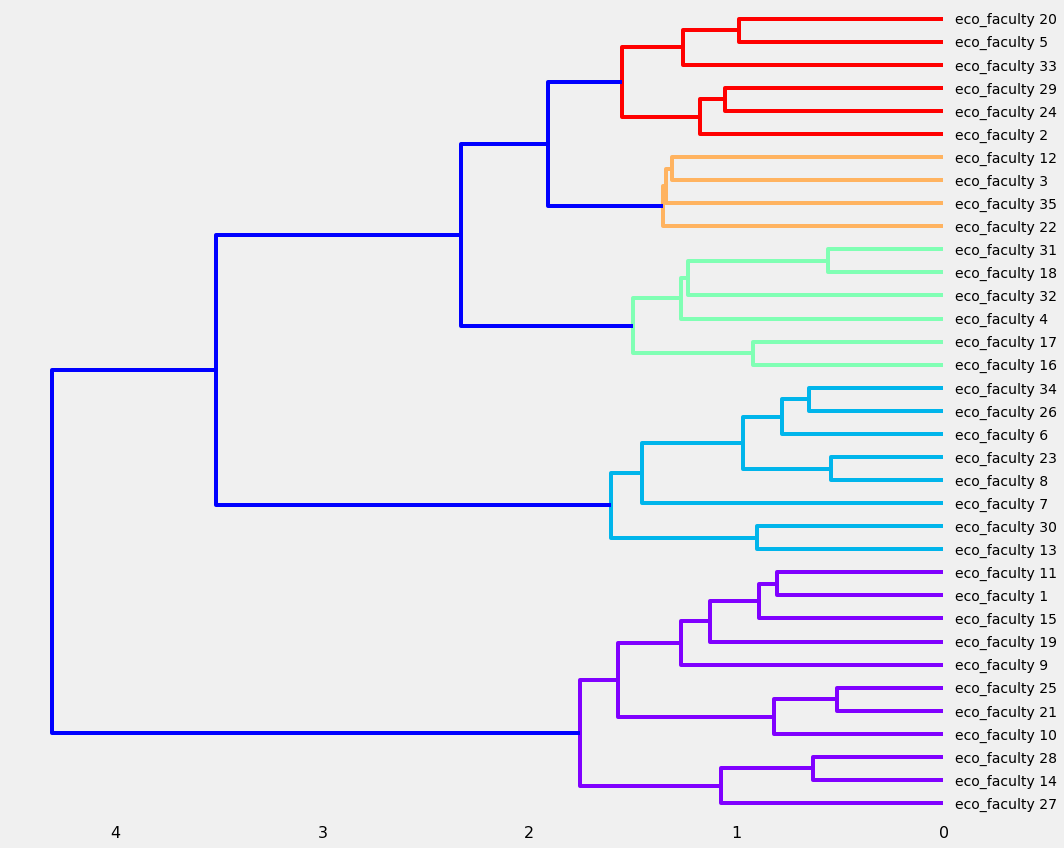

In [130]:
cmap = cm.rainbow(np.linspace(0, 1, 5))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15, 12)) 
ax.grid(False)
titles=eco_faculty.index

ax=dendrogram(linkage_matrix, 
                orientation="left", 
                color_threshold=1.8,
                leaf_font_size=14,
                labels=titles);

plt.tick_params(\
    axis= 'x',          
    which='both',    
    bottom='off',      
    top='off', 
    labelbottom='off')


plt.tight_layout() 
plt.show()

# Word clouds
Now let's take a look inside and plot [wordclouds](https://github.com/amueller/word_cloud) to see what are representative words in each cluster. To do so, I am going to sum up `TF-IDF` vectors of all the faculty members in each cluster to get a vector representing that cluster and plot the wordcloud using the obtained vector:

First let's make a look-up table to map clusters numbers to their corresponding faculty members:

In [77]:
cluster_numbers=fcluster(linkage_matrix,t=1.8,criterion='distance')
unique_clusters=set(cluster_numbers)
cluster_to_faculty_dic={i:[] for i in unique_clusters}
for i,cluster_number in enumerate(cluster_numbers):
    cluster_to_faculty_dic[cluster_number].append(tfidf_df.index[i])

Now we'll calculate the representative sun vector and fit a wordcloud on it:

In [97]:
wordcloud_dic={}
for key in cluster_to_faculty_dic.keys():
    words_freq=tfidf_df.loc[cluster_to_faculty_dic[key],:].sum()
    wordcloud_dic[key]=WordCloud(stopwords=stopwords,width=1600, height=800,
                        background_color='white',normalize_plurals=True,
                        ).fit_words(words_freq)

and plot them

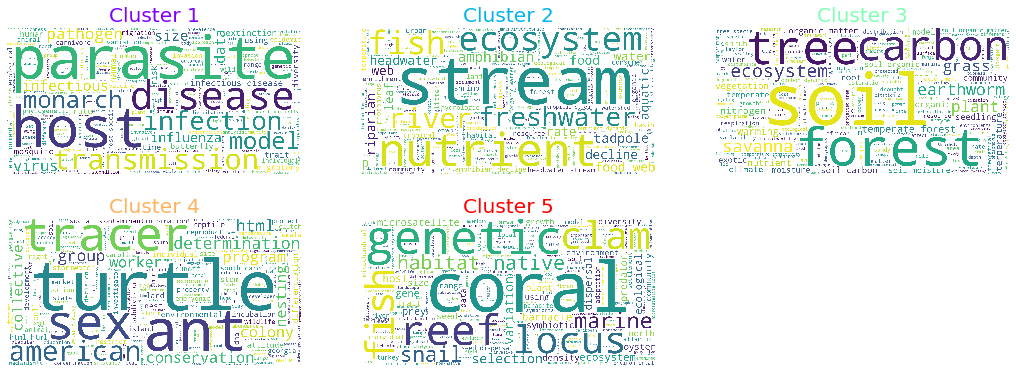

In [134]:
fig,axes=plt.subplots(2,3,figsize=(16,6),facecolor='white')
for i,key in enumerate(cluster_to_faculty_dic.keys()):
    ax=axes[i//3,i%3]
    ax.imshow(wordcloud_dic[key])
    ax.axis('off')
    ax.set_title('Cluster ' + str(i+1),color=cmap[i][:3])

ax=axes[1,-1]
ax.axis('off')
ax.set_facecolor('white')



plt.show()
    

Viola! We see distintive difference between wordclouds of clusters, each representing a particular sub-filed of research in ecology!

I am going to pickle the TF-IDF matrix to use it in second part of this project titled [Coauthor graph](https:\\link-to-part2):

In [135]:
tfidf_df.to_pickle('tfidf_df.pickle')